# 04. PyTorch Custom dataset Video Notebook

How do you get your own data into PyTorch?

One of the way to do so is via: customs dataset

## Domain libraries

Depending on what you´re working on, vision, text, audio, etc... 

You´ll want to look into each PyTorch domain libraries for existing data loading functions and customizable data loading functions.


## 0. Importing PyTorch and setting up device-agnostic code


In [1]:
import torch
from torch import nn

# Note: PyTroch 1.10.0 + os required for this course
torch.__version__

'1.12.1+cu113'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get data

Our dataset is a subset of the food101 dataset.

Food101 starts 101 differentes classes of food.

Our dataset starts with 3 classes of food and only 10% of the images ( about 75 training, 25 testing per class)

Why do this?

When starting out ML projects, it´s inportant to try things on a small scale and then increase the scale when necessar.

The whole point is to speed up how fast you can experiment

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_shushi"

# Iif the image folder doesn´t exist, download it and prepare it

if image_path.is_dir():
  print(f'{image_path} directoyry already exists .... skipping download')
else:
  print(f'Creating path: {image_path}')
  image_path.mkdir(parents=True, exist_ok = True)

# Download zip
with open(data_path / 'pizza_steak_shushi.zip', 'wb') as f:
  
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print('Downloading pizza_steak_sushi.zip')
  
  f.write(request.content)

# Unzip pizza, stacke, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_shushi.zip', 'r') as zip_ref:
  print('Unzipping pizza, steak, sushi data')
  zip_ref.extractall(image_path)

data/pizza_steak_shushi directoyry already exists .... skipping download
Unzipping pizza, steak, sushi data


## Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [5]:
walk_through_dir(data_path)

There are 1 directories and 1 images in data
There are 2 directories and 0 images in data/pizza_steak_shushi
There are 3 directories and 0 images in data/pizza_steak_shushi/test
There are 0 directories and 31 images in data/pizza_steak_shushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_shushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_shushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_shushi/train
There are 0 directories and 72 images in data/pizza_steak_shushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_shushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_shushi/train/steak


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir 

(PosixPath('data/pizza_steak_shushi/train'),
 PosixPath('data/pizza_steak_shushi/test'))

### 2.1 Visualizing an Image

Let´s write some code to:
1. Get all of image paths
2. Pick a random image path using Python´s random.choice()
3. Get image class name 'pathlib.Path.parent.stem'
4. Since we´re working with images, let´s open the image with Python PIL
5. We´ll then show the image and print metadata


Random image path: data/pizza_steak_shushi/train/sushi/794647.jpg
Random image path: data/pizza_steak_shushi/train/sushi/794647.jpg
Image class: sushi
Image Height: 512
Image widht: 512


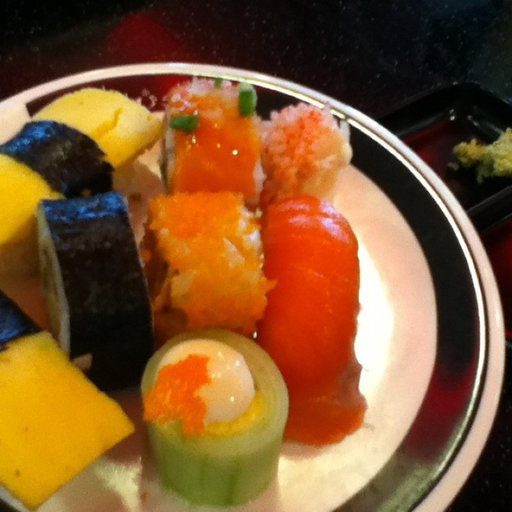

In [7]:
import random
from PIL import Image
# Set the seed
#random.seed(42)

# 1. Get all the image paths ()
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path

random_image_path = random.choice(image_path_list)
print(f'Random image path: {random_image_path}')

# 3. Get image class form the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
image_class

# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image widht: {img.width}')
img



(-0.5, 511.5, 511.5, -0.5)

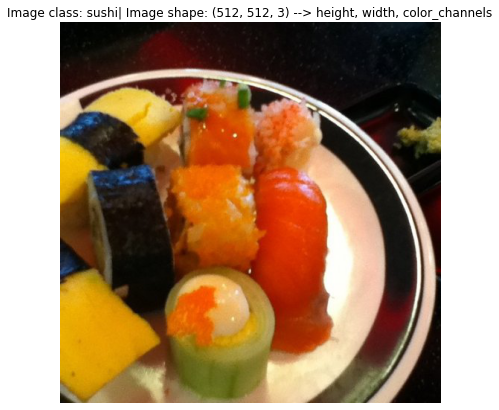

In [8]:
# Try to visualize and image with matplot lib ...
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array

img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class}| Image shape: {img_as_array.shape} --> height, width, color_channels')
plt.axis(False)

## 3. Transforming Data

Before we can use our image data with PyTorch: 
1. Turn your target data into tensors (in our case, numerical representation of 
our images)
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.utils.data.DataLoader, we´ll call these 'dataset' and 'DataLoader'.


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transform

In [10]:
# Write a transform for image

data_transform = transforms.Compose([
    # Resize our images
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.0471, 0.0157, 0.0196,  ..., 0.0078, 0.0078, 0.0078],
         [0.0471, 0.0314, 0.0235,  ..., 0.0118, 0.0118, 0.0078],
         [0.0588, 0.0471, 0.0275,  ..., 0.0157, 0.0157, 0.0078],
         ...,
         [0.0235, 0.0235, 0.0196,  ..., 0.7412, 0.6353, 0.5608],
         [0.0196, 0.0235, 0.0196,  ..., 0.6275, 0.5529, 0.3961],
         [0.0157, 0.0157, 0.0196,  ..., 0.5529, 0.3333, 0.1412]],

        [[0.0667, 0.0471, 0.0588,  ..., 0.0157, 0.0157, 0.0157],
         [0.0706, 0.0627, 0.0588,  ..., 0.0196, 0.0196, 0.0157],
         [0.0824, 0.0706, 0.0588,  ..., 0.0235, 0.0235, 0.0157],
         ...,
         [0.0196, 0.0196, 0.0157,  ..., 0.5451, 0.4980, 0.5020],
         [0.0157, 0.0196, 0.0157,  ..., 0.4980, 0.4941, 0.3686],
         [0.0118, 0.0118, 0.0157,  ..., 0.5020, 0.3098, 0.1216]],

        [[0.0667, 0.0510, 0.0745,  ..., 0.0118, 0.0118, 0.0118],
         [0.0588, 0.0588, 0.0667,  ..., 0.0157, 0.0157, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0118, 0.0118, 0.

### 3.1 Transforming data with 'torchvision.transforms'

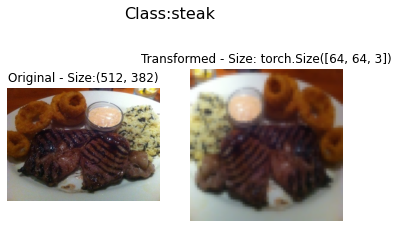

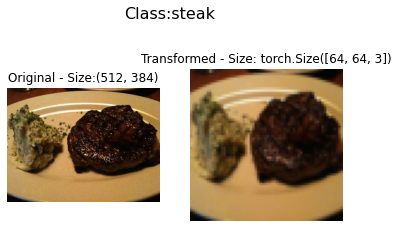

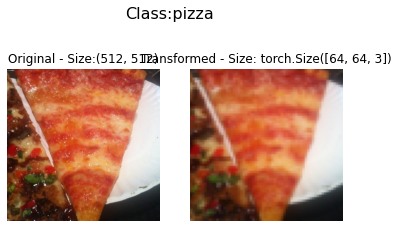

In [12]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original
  vs the transform version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original - Size:{f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Note we will need to change shape for matplolib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed - Size: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class:{image_path.parent.stem}', fontsize = 16)
  

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        )

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using torchvision.dataset.ImageFolder

In [13]:
# Use ImageFolder to create a dataset

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # Transform for the data
                                  target_transform = None,
                                  )    # Transform for the labels


test_data = datasets.ImageFolder(
    root=test_dir,
    transform = data_transform,
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_shushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_shushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get classes as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get classes as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lenghts of our datasets
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[:5]

[('data/pizza_steak_shushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_shushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_shushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_shushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_shushi/train/pizza/1105700.jpg', 0)]

In [18]:
# Index on the train data DataSet to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label: {class_names[label]}')

print(f'Image label datatype: {type(label)}')



Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape:torch.Size([3, 64, 64]) - Permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

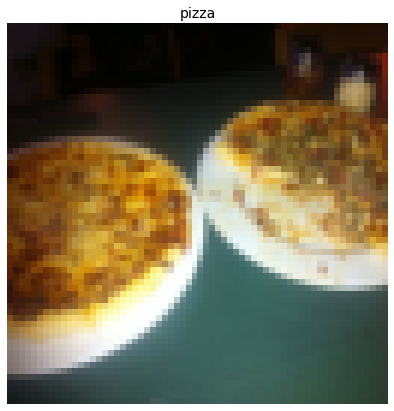

In [19]:
# Rearrange the order or dimensions
img_permuted = img.permute(1,2,0)
print(f'Original shape:{img.shape} - Permuted shape: {img_permuted.shape}')

# Plot the image

plt.figure(figsize=(10,7))
plt.imshow(img_permuted)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into DataLoaders

a DataLoader is going to help us turn our datasets into iterables and we can custimise the batch size, so our model can see batch size images at time

In [20]:
import os
os.cpu_count()

2

In [21]:
# Turn train and Test datasets into DataLoader´s
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 1
train_data_loader = DataLoader(dataset=train_data,
                               batch_size = BATCH_SIZE,
                               num_workers = 1,
                               shuffle = True)
    
test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = 1,
    shuffle = True
)

In [22]:
len(train_data_loader), len(test_data_loader)


(225, 75)

In [23]:
img, label = next(iter(train_data_loader))

# Batch size will now be 1, you can change batch size if you want
print(f'Image shape: {img.shape}') # ----> [batch_size, colours_channels, height, width]
print(f'Label: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64])
Label: torch.Size([1])


## 5 Option 2: Loading Image data with a Custom Dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create a 'DataSet' out of almos anything
* Not limited to PyTorch pre-built 'Dataset' functions

Cons:
* Even though you could create 'DataSet' out of almost anything, it doesn´t mean it will work.
* Using a custom 'DataSet' often results in us writting more code, which could be prone to errors or perfomance issues.


All custom dataset ofte subclass Dataset

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names aren´t found ( if this happens, there might be something wrong with the directoyry structure)
3. Turn the classes names into a dict and a list and return them.



In [26]:
# Setup path for target directory:
target_directory = train_dir
print(f'Target dir:{target_directory}')

# Get the class names from the target directory:
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir:data/pizza_steak_shushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str],Dict[str,int]]:
  """Finds the classes folder names in a targe directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in list(os.scandir(directory))])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Coudn´t find any classes in {directory}, please check file structure")
  
  # 3. Create a directory of index labels ( computers prefers numbers rather than strings as labels)
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom 'Dataset' to replicate 'ImageFolder'

To create our own custom dataset, we want to:

1. Subclass 'torch.utils.data.Dataset'
2. Init our subclass with target directory (the directory we´d like to get data from) as well as transform if we´d like to transform our data.
3. Create severtal attributes:
  * paths - paths of our images
  * transform - the transform we´d like to use.
  * classes - a list of the target classes.
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to 'load_images()', this function will open an image.
5. Overwrite the '__len__()' method to return the length of our dataset
6. Overwrite the 'getitem()' method to return a given sample when passed an index


In [29]:
# Write a custom dataset class

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform = None):
    
    # 3. Create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transform
    self.transforms = transform
    # Create classes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_images(self, index: int)->Image.Image:
    """Open an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  #5. Overwrite the len() method
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  #6. Overwrite the getitem()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Return one sample of data, data and label (X,y)"""
    img = self.load_images(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder / class_name / image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necesary
    if self.transforms:
      return self.transforms(img), class_idx
    else:
      return img, class_idx

In [30]:
# Createa a transforms
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transform)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transform)

In [32]:
len(train_data_custom), len (train_data)

(225, 225)

In [33]:
len(test_data_custom), len (test_data)


(75, 75)

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality between original ImageFolder dataset and ImageFolderCustomDataset
print(train_data_custom.classes  == train_data.classes)
print(test_data_custom.classes  == test_data.classes)


True
True


### 5.3 Create a function to display random images


1. Take in a 'Dataset' and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of handa, let´s cap the number of images to see at 10.
3. Set a random seed for reproducibility
4. Get a list of random sample indexes from the entire dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib

In [36]:
# 1. Create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is to hight
  if n > 10:
    n = 10
    display_shape = False
    print('For display, purposes,, n shouldn´t be larger than 10.')
  # 3. Set a random seed
  if seed:
    random.seed(seed)
  # 4. Get a list of random sample indexes
  random_samples_idx = random.sample(
      range(
          len(dataset)), k=10
           )
  # 5. Setup plot
  plt.figure(figsize=(16,8))
  # 6. Loop throug random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]
  
  #7. Adjust tensor dimension for ploting
    targ_image_adjust = targ_image.permute(1,2,0)

  # Plot adjusted sampls
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f' shape:{targ_image_adjust.shape}'
    plt.title(title)

     

For display, purposes,, n shouldn´t be larger than 10.


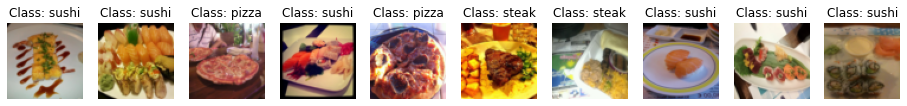

In [37]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes = class_names,
                      seed=None)

### 5.4 Turn custom loaded images into DataLoader´s

In [38]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size = BATCH_SIZE,
                                      num_workers = NUM_WORKERS,
                                      shuffle = True)

test_data_loader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False,
)

train_data_loader_custom, test_data_loader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fbf86f42bd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbf86f422d0>)

In [39]:
# Get image and label from custom data loader
img_custom, label = next(iter(train_data_loader_custom))
img_custom.shape, label

(torch.Size([32, 3, 64, 64]),
 tensor([2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 2, 1, 2, 0, 0]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Data Augmentation: Lookking at the same image bug from different perspective.
To artificially increase the diversity of a dataset.

This practice hopefully results in a model that´s more generalizable to unseen data.

Let´s take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels ...

In [40]:
# Let´s look at trivial augment
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
transforms.Resize(size=(224,224)),
transforms.ToTensor()    
])

In [41]:
# Get all images paths

image_path_list = list(image_path.glob("*/*/*.jgp"))
image_path_list[:10]

[]

In [42]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_shushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/175783.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_shushi/test/sushi/1434806.jpg')]

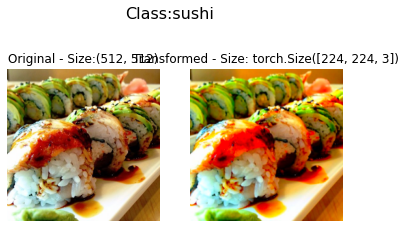

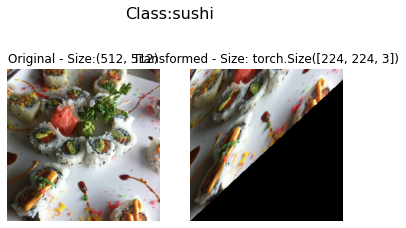

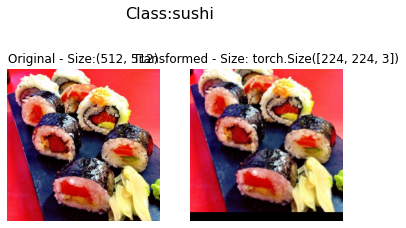

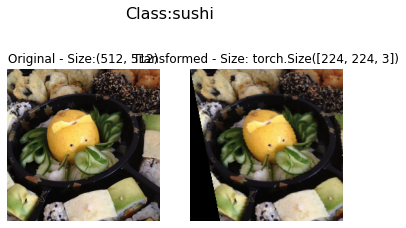

In [43]:
# Plot transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 4,
    seed = None)

## 7. Model 0: Tiny VGG without data augmentation

Let´s replicate the TinyVGG from CNN explainer

### 7.1 Creating transforms and loading data for Model0

In [44]:
# Create a simple transform
from torchvision import transforms


simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [45]:
# Loading image data using ImageFolder
from torchvision import datasets
from torch.utils.data import DataLoader
import os


train_data = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform,
    target_transform = None,

)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform,
)

# Default values
BATCH_SIZE = 32
WORKERS = os.cpu_count()
# Data Loader

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = WORKERS,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = WORKERS,
    shuffle = False
)

### 7.2 Create a TinyVGG module class



In [54]:
from torch import nn

class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ) -> None:
    super().__init__(),
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)

            
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels= hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)

            
        )
   
        
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= 1690,
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classfier(self.conv_block_2(self.conv_block_1(x)))   --> benefits from operation fusion
    

In [55]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass in a single image (to test the model)

In [56]:
# Get a single image batch

image_batch, label_batch= next(iter(train_data_loader))


model_0(image_batch)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2870e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7294e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8249e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [57]:
# Try a forward pass
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

  

summary(model_0, input_size=(1, 3, 64, 64))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create a train and test loops function

* train_step() - takes in a model and dataloader and trains the model on the dataloader
*test_step() - takes in a model and dataloader an evaluates the model on the dataloader.

In [58]:
# Create train_step()

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(data_loader):
    # Send the data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # 3. Optimizer zedo grad
    optimizer.zero_grad()
    # 4. Backwward
    loss.backward()
    # 5. Step 
    optimizer.step()

    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust metrics to get the average loss and accuracy
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)

  return train_loss, train_acc



In [59]:
# Create a test_step()

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device = device):
  # Put model in eval mode
  model.eval()
  # Setup test and accuracy values
  test_loss, test_acc = 0, 0
  # Turn on inference mode
  with torch.inference_mode():
    # Loop throug dataloader batches
    for batch, (X_test,y_test) in enumerate(data_loader):
      # pass data to device
      X_test, y_test = X_test.to(device), y_test.to(device)
      # Forward pass
      test_pred_logits = model(X_test)

      # Calculate the loss 
      loss = loss_fn(test_pred_logits, y_test)
      test_loss += loss.item()
      # Calculate the accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim = 1),dim = 1)
      test_acc += (test_pred_labels == y_test).sum().item() / len(test_pred_logits)
    
  test_loss = test_loss / len(data_loader)
  test_acc = test_acc / len(data_loader)

  return test_loss, test_acc


In [60]:
# Functionalize train and test step to train a model
from tqdm.auto import tqdm
# 1- Create a train function that takes in various model parameters
def train(
    model: torch.nn.Module,
    train_data_loader: torch.utils.data.DataLoader,
    test_data_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device = device
  ):
  # Create a empty result diccinary
  results = {"train_loss":[],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model = model,
                                       data_loader = train_data_loader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                     data_loader = test_data_loader,
                                     loss_fn = loss_fn,
                                     device = device)
    
    # Print out what´s happening
    print(f'Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}')

    # Update our model diccionary:
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
    
  return results


### 7.7 Train and evaluante model 0

In [61]:
# Setup a loss function and a optimizer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of epochs
NUM_EPOCHS = 50

# Recreate a new instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_0.parameters(),
    lr = 0.0001,

)
# Start timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model = model_0,
      train_data_loader = train_data_loader,
      test_data_loader = test_data_loader,
      optimizer = optimizer,
      loss_fn = loss_fn,
      device = device,
      epochs = NUM_EPOCHS)

# End the timer and print how long it took.
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.0990 | train_acc: 0.30 | test_loss: 1.0979 | test_acc: 0.26
Epoch: 1 | train_loss: 1.0995 | train_acc: 0.30 | test_loss: 1.0939 | test_acc: 0.30
Epoch: 2 | train_loss: 1.0963 | train_acc: 0.43 | test_loss: 1.0942 | test_acc: 0.53
Epoch: 3 | train_loss: 1.0995 | train_acc: 0.28 | test_loss: 1.0918 | test_acc: 0.54
Epoch: 4 | train_loss: 1.0954 | train_acc: 0.42 | test_loss: 1.0932 | test_acc: 0.57
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.43 | test_loss: 1.0904 | test_acc: 0.54
Epoch: 6 | train_loss: 1.0933 | train_acc: 0.41 | test_loss: 1.0850 | test_acc: 0.54
Epoch: 7 | train_loss: 1.1004 | train_acc: 0.28 | test_loss: 1.0809 | test_acc: 0.54
Epoch: 8 | train_loss: 1.1013 | train_acc: 0.28 | test_loss: 1.0838 | test_acc: 0.54
Epoch: 9 | train_loss: 1.0918 | train_acc: 0.40 | test_loss: 1.0863 | test_acc: 0.54
Epoch: 10 | train_loss: 1.0901 | train_acc: 0.40 | test_loss: 1.0839 | test_acc: 0.54
Epoch: 11 | train_loss: 1.0953 | train_acc: 0.28 | test_loss: 1.

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model´s progress through epochs.


In [62]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plot training curves of a results dictionary"""
  # Get the loss values of the results dictionary(Training and test)
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # Accuracy
  train_accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Epochs
  epochs = range(len(results['train_acc']))

  # Setup a plot
  plt.figure(figsize=(15,7))
  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label = 'Train_Loss')
  plt.plot(epochs, test_loss, label = 'Test_Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label = 'Train Accuracy')
  plt.plot(epochs, test_accuracy, label = 'Test Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  



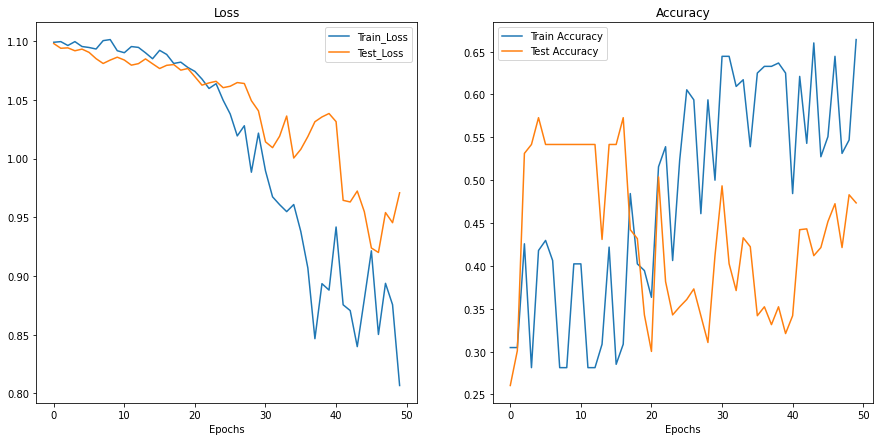

In [63]:
plot_loss_curves(model_0_results)

## 8 What should an ideal loss curve look like?

## 9 Model TinyVGG with data Augmentation

Now let´s try another modeling experiment this time using the same model as before but with some data augmentation

### 9.1 Create a transform with data augmentation

In [70]:
# Create training transform with TrivialAugmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



### 9.2 Create tranin and test datasets and DataLoaders with data augmentation

In [74]:
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform_trivial,
)

test_data_augmented = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform_simple,
)




In [75]:
# Turn dataset into dataloader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_augmented_data_loader = DataLoader(
    dataset = train_data_augmented,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True
)

test_augmented_data_loader = DataLoader(
    dataset = test_data_augmented,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

## 9.3 Construct a train model 1

This time we´ll using the sme model architecture expcet this time we´ve applied data augmentation-

In [79]:
# Create Model 1 and send it to model device

torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data_augmented)
).to(device)
model_1 

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=225, bias=True)
  )
)

In [95]:
# Create a loss function and a optimizer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_1.parameters(),
    lr = 0.001
)

# Start timer

from timeit import default_timer as timer
start_train_ = timer()

model_1_results = train(
    model = model_1,
    train_data_loader = train_augmented_data_loader,
    test_data_loader = test_augmented_data_loader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = EPOCHS,
    device = device
)

end_time_ = timer()

print(f'Total training time: {end_time_ - start_train_:.3f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.9026 | train_acc: 0.61 | test_loss: 1.0979 | test_acc: 0.35
Epoch: 1 | train_loss: 1.0491 | train_acc: 0.48 | test_loss: 1.0560 | test_acc: 0.38
Epoch: 2 | train_loss: 0.9226 | train_acc: 0.49 | test_loss: 1.0273 | test_acc: 0.43
Epoch: 3 | train_loss: 0.8459 | train_acc: 0.58 | test_loss: 1.2108 | test_acc: 0.33
Epoch: 4 | train_loss: 0.8491 | train_acc: 0.59 | test_loss: 1.0737 | test_acc: 0.41
Epoch: 5 | train_loss: 0.8805 | train_acc: 0.66 | test_loss: 0.9992 | test_acc: 0.42
Epoch: 6 | train_loss: 0.8139 | train_acc: 0.62 | test_loss: 0.9735 | test_acc: 0.42
Epoch: 7 | train_loss: 0.8012 | train_acc: 0.67 | test_loss: 0.9931 | test_acc: 0.43
Epoch: 8 | train_loss: 0.8682 | train_acc: 0.52 | test_loss: 1.0226 | test_acc: 0.43
Epoch: 9 | train_loss: 0.8118 | train_acc: 0.63 | test_loss: 0.9004 | test_acc: 0.59
Epoch: 10 | train_loss: 0.8506 | train_acc: 0.61 | test_loss: 1.0970 | test_acc: 0.36
Epoch: 11 | train_loss: 0.8237 | train_acc: 0.59 | test_loss: 1.

### 9.4 Plot the loss curves of model 1

A loss curve help you evaluate your models perfomance over time

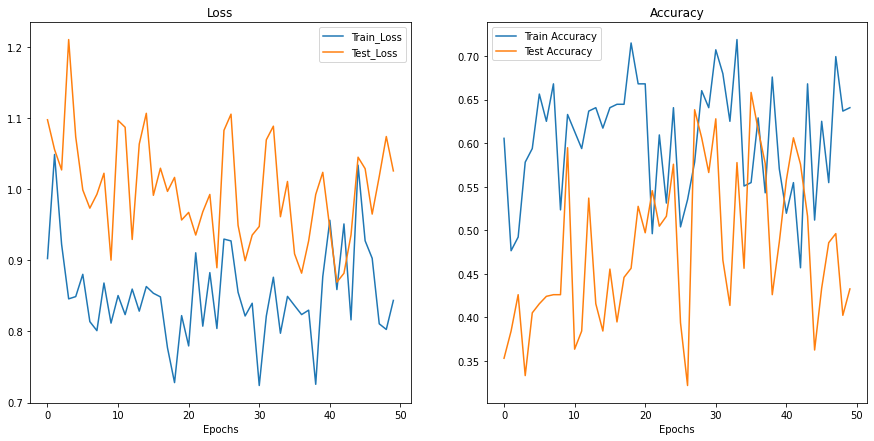

In [96]:
plot_loss_curves(model_1_results)

## 10 Compare model Results

After evaluating our modelling experiments on their own, it´s important to compare them to each other.

There´s few different to do this:

1. Hard coding (what we are doing)
2. PyTorch + Tensorboard
3. Weight & Biases
4. MLflow



In [102]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df.head()

,train_loss,train_acc,test_loss,test_acc
0,1.099007,0.304688,1.097917,0.260417
1,1.099540,0.304688,1.093888,0.301136
2,1.096260,0.425781,1.094238,0.531250
3,1.099547,0.281250,1.091755,0.541667
4,1.095390,0.417969,1.093172,0.572917


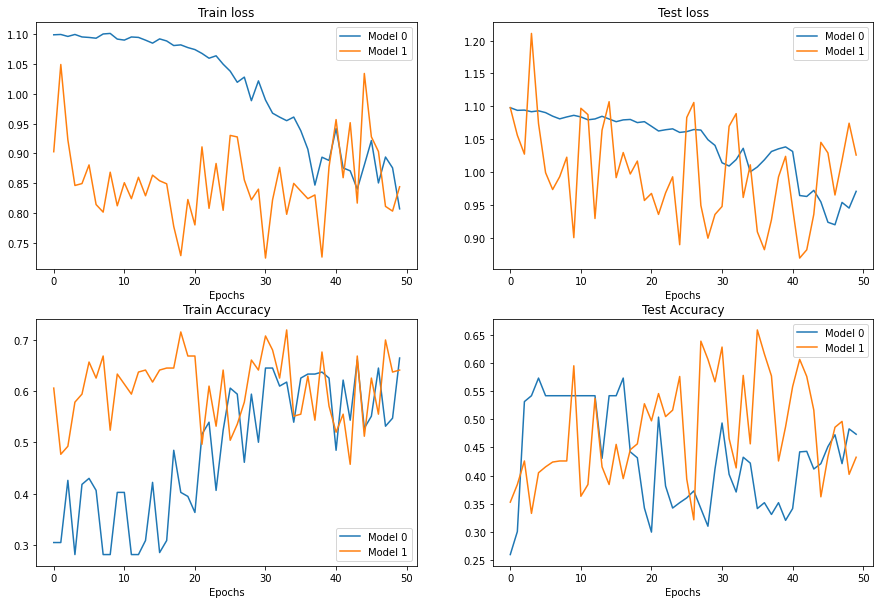

In [103]:
# Set up a plot
plt.figure(figsize=(15,10))
# Get number of epochs
epochs = range(len(model_0_df))

# Plot for train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_loss'], label = 'Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_acc'], label = 'Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_acc'], label = 'Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

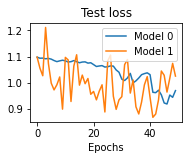